## System Vulnerabilities Analysis of EBMUD Water Distribution System in NetworkX ##

Install Packages

In [1]:
import pandas as pd 
import geopandas as gpd
%pip install matplotlib 
import matplotlib.pyplot as plt
import networkx as nx
%pip install seaborn
import seaborn as sns 
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Read in Data

In [2]:
# Load node list from CSV
# Assuming the CSV has columns: 'node_id' and optionally other attributes
node_csv_path = "/home/veronica/data/node_list_dc_btwn.csv"
nodes_df = pd.read_csv(node_csv_path)

# Load edge list from CSV
# Assuming the CSV has columns: 'source', 'target' and optionally other attributes
edge_csv_path = "/home/veronica/data/edge_list.csv"
edges_df = pd.read_csv(edge_csv_path)

In [3]:
# Assuming your DataFrame is named 'df' and the column containing betweenness centrality is named 'betweenness_centrality'

# Find the maximum and minimum values
max_value = nodes_df['Betweenness Centrality'].max()
min_value = nodes_df['Betweenness Centrality'].min()
avg_value = nodes_df['Betweenness Centrality'].mean()

# Print the results
print(f"Maximum Betweenness Centrality: {max_value}")
print(f"Minimum Betweenness Centrality: {min_value}")
print(f"Average Betweenness Centrality: {avg_value}")

Maximum Betweenness Centrality: 841995273363.3473
Minimum Betweenness Centrality: 0.0
Average Betweenness Centrality: 4334845963.059091


Build NetworkX Graph from NetworKit csv files

In [4]:
# Create an empty NetworkX graph
G = nx.Graph()

In [5]:
# Add nodes with attributes
for _, row in nodes_df.iterrows():
    node_id = row['Node ID']
    attributes = row.drop('Node ID').to_dict()  # Convert other columns to attributes
    G.add_node(node_id, **attributes)

# Add edges with attributes
for _, row in edges_df.iterrows():
    source = row['Source']
    target = row['Target']
    attributes = row.drop(['Source', 'Target']).to_dict()  # Convert other columns to attributes
    G.add_edge(source, target, **attributes)

# Verify the graph is created
print("Number of nodes in NetworkX graph:", G.number_of_nodes())
print("Number of edges in NetworkX graph:", G.number_of_edges())

Number of nodes in NetworkX graph: 1372418
Number of edges in NetworkX graph: 1384839


In [6]:
# Assuming 'G_sub_nx' is your NetworkX graph and betweenness centrality is already calculated as a node attribute

# Find the node with the maximum betweenness centrality
max_node = max(G.nodes, key=lambda node: G.nodes[node].get('Betweenness Centrality', 0))
max_value = G.nodes[max_node].get('Betweenness Centrality', 0)

# Print the results
print(f"Node with maximum betweenness centrality: {max_node}")
print(f"Maximum betweenness centrality value: {max_value}")

Node with maximum betweenness centrality: 328482.0
Maximum betweenness centrality value: 841995273363.3473


In [7]:
print(attributes.keys())

dict_keys(['Weight'])


In [8]:
# Convert DataFrame to a dictionary of dictionaries
attributes = nodes_df.set_index('Node ID').to_dict('index')

# Assign attributes to the graph
nx.set_node_attributes(G, attributes)

In [9]:
# Create a DataFrame from the NetworkX graph
nodes_df = pd.DataFrame(G.nodes(data=True), columns=['Node ID', 'Attributes'])
edges_df = pd.DataFrame(G.edges(data=True), columns=['Source', 'Target', 'Attributes'])

# Save the node and edge DataFrames to CSV
nodes_df.to_csv("/home/veronica/data/nodes_nx.csv", index=False)
edges_df.to_csv("/home/veronica/data/edges_nx.csv", index=False)

Identify Largest Connected Component for Analysis

In [10]:
# Identify the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph containing only the nodes in the largest connected component
G_sub_nx = G.subgraph(largest_cc).copy()  # Use `.copy()` to ensure it's a standalone graph

# Verify the node list remains the same
print("Number of nodes in NetworkX subgraph:", G_sub_nx.number_of_nodes())
print("Number of edges in NetworkX subgraph:", G_sub_nx.number_of_edges())

Number of nodes in NetworkX subgraph: 1351853
Number of edges in NetworkX subgraph: 1364767


In [11]:
# Assuming 'G_sub_nx' is your NetworkX graph and betweenness centrality is already calculated as a node attribute

# Find the node with the maximum betweenness centrality
max_node = max(G_sub_nx.nodes, key=lambda node: G_sub_nx.nodes[node].get('Betweenness Centrality', 0))
max_value = G_sub_nx.nodes[max_node].get('Betweenness Centrality', 0)

# Print the results
print(f"Node with maximum betweenness centrality: {max_node}")
print(f"Maximum betweenness centrality value: {max_value}")

Node with maximum betweenness centrality: 328482.0
Maximum betweenness centrality value: 841995273363.3473


In [12]:
# Create a DataFrame from the subgraph
nodes_df_sub = pd.DataFrame(G_sub_nx.nodes(data=True), columns=['Node ID', 'Attributes'])
edges_df_sub = pd.DataFrame(G_sub_nx.edges(data=True), columns=['Source', 'Target', 'Attributes'])

# Save the subgraph node and edge DataFrames to CSV
nodes_df_sub.to_csv("/home/veronica/data/nodes_nx_sub.csv", index=False)
edges_df_sub.to_csv("/home/veronica/data/edges_nx_sub.csv", index=False)

# Targetted Attacks ##

Nodes sorted by Degree for Subnetwork

In [13]:
N = G_sub_nx.number_of_nodes()
number_of_steps = 100
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G_sub_nx.copy()
targeted_attack_core_proportions_d = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = max(nx.connected_components(C), key=len)
    core_proportion = len(core) / N
    targeted_attack_core_proportions_d.append(core_proportion)

    # If there are more than M nodes, select top M nodes and remove them
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)

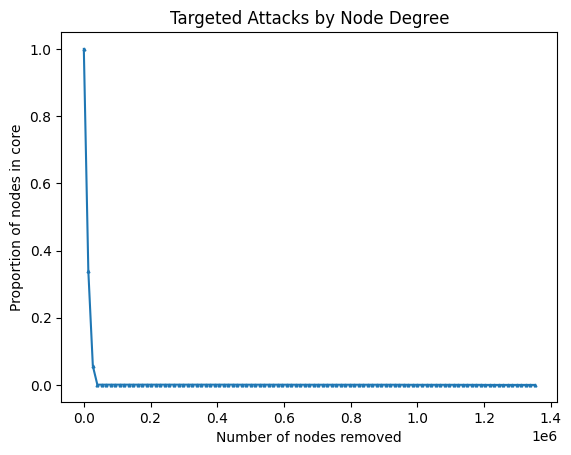

In [14]:
plt.title('Targeted Attacks by Node Degree')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions_d, marker='^', markersize=2)

In [15]:
# Print value of M
print("Value of M:", M)

Value of M: 13518


In [16]:
# Calculate the number of nodes removed in first 3 steps
num_nodes_removed_first_3_steps = 3 * M
print("Number of nodes removed in first 3 steps:", num_nodes_removed_first_3_steps)

Number of nodes removed in first 3 steps: 40554


In [17]:
# Save the results to a CSV file
results_df = pd.DataFrame({
    'Nodes Removed': num_nodes_removed,
    'Core Proportion': targeted_attack_core_proportions_d
})
results_df.to_csv('/home/veronica/data/degree_attack_results.csv', index=False)

Nodes sorted by Betweenness Centrality for Subnetwork

0 1.0
13518 0.6652823938697476
27036 0.6263713584243257
40554 0.5748028816742649
54072 0.4628942643911727
67590 0.38797783486814025
81108 0.3487598133820763
94626 0.2551904681943969
108144 0.24022212474285295
121662 0.23208218645074574
135180 0.21770932194550738
148698 0.14281286500825163
162216 0.12336844316652772
175734 0.09156616880681553
189252 0.08679272080618233
202770 0.08565946149470394
216288 0.07964771317591483
229806 0.026769922469380918
243324 0.025215019680394243
256842 0.02438208888096561
270360 0.023362747280954364
283878 0.02261266572622911
297396 0.02119017378368802
310914 0.020853598727080532
324432 0.015063028302633496
337950 0.012680372792012149
351468 0.009825772476741185
364986 0.007876596050014313
378504 0.007252267813142406
392022 0.006921610559728018
405540 0.006683418981205797
419058 0.006090898936496793
432576 0.005659639028799729
446094 0.005371146123136169
459612 0.005215064063918192
473130 0.005144790151000145
486648 0.004081804752439799
500166 0.004036681

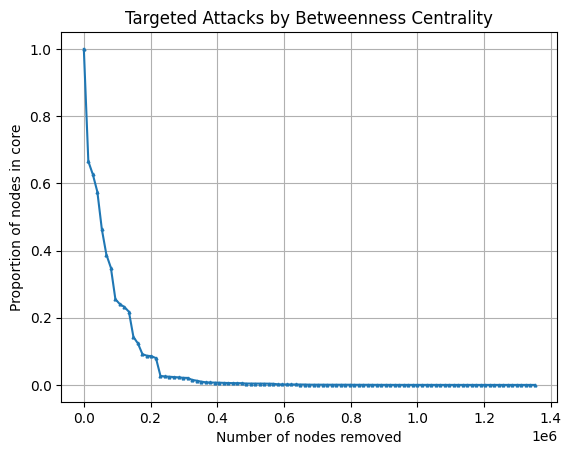

In [18]:
# Adopted code from Marta
# Assuming betweenness centrality values are stored in the `attributes` dictionary
N = G_sub_nx.number_of_nodes()
number_of_steps = 100
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G_sub_nx.copy()
targeted_attack_core_proportions_btwn = []

############# Check the copy
# Convert nodes to DataFrame
nodes_df_sub = pd.DataFrame(C.nodes(data=True), columns=['Node ID', 'Attributes'])

# Expand attribute dictionary into separate columns
nodes_df_sub = nodes_df_sub.join(pd.json_normalize(nodes_df_sub.pop("Attributes")))

# Sort by "Betweenness Centrality" in descending order
nodes_df_sub = nodes_df_sub.sort_values(by="Betweenness Centrality", ascending=False)

# Save to CSV
nodes_df_sub.to_csv("/home/veronica/data/copy_nodes_nx_sub.csv", index=False)

# Convert edges to DataFrame (unchanged)
edges_df_sub = pd.DataFrame(C.edges(data=True), columns=['Source', 'Target', 'Attributes'])
edges_df_sub = edges_df_sub.join(pd.json_normalize(edges_df_sub.pop("Attributes")))
edges_df_sub.to_csv("/home/veronica/data/copy_edges_nx_sub.csv", index=False)

for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = max(nx.connected_components(C), key=len)
    core_proportion = len(core) / N

    # Save the largest connected component (core) nodes and edges to CSV
    C_core = C.subgraph(core).copy()  # Create a subgraph of the largest connected component

    # Save core nodes to CSV
    core_nodes_df = pd.DataFrame(C_core.nodes(data=True), columns=['Node ID', 'Attributes'])
    core_nodes_df = core_nodes_df.join(pd.json_normalize(core_nodes_df.pop("Attributes")))

    # Calculate log of betweenness centrality
    if 'Betweenness Centrality' in core_nodes_df.columns:
        core_nodes_df['Log Betweenness Centrality'] = np.log(core_nodes_df['Betweenness Centrality'].replace(0, np.nan))

    core_nodes_df.to_csv(f"/home/veronica/data/TA_Core_Nodes/core_nodes_{nodes_removed}.csv", index=False)

    # Save core edges to CSV
    core_edges_df = pd.DataFrame(C_core.edges(data=True), columns=['Source', 'Target', 'Attributes'])
    core_edges_df = core_edges_df.join(pd.json_normalize(core_edges_df.pop("Attributes")))
    core_edges_df.to_csv(f"/home/veronica/data/TA_Core_Edges/core_edges_{nodes_removed}.csv", index=False)

    targeted_attack_core_proportions_btwn.append(core_proportion)
    print(nodes_removed,core_proportion)

    # If there are more than M nodes, select top M nodes by betweenness centrality and remove them
    if C.number_of_nodes() > M:
        # Ensure node IDs match the keys in the attributes dictionary
        nodes_sorted_by_betweenness = sorted(
            C.nodes, 
            key=lambda node: attributes[int(node)]['Betweenness Centrality'],  # Convert node ID to int if necessary
            reverse=True
        )
        nodes_to_remove = nodes_sorted_by_betweenness[:M]
        C.remove_nodes_from(nodes_to_remove)        

    # Save removed nodes and their attributes to a csv file
        removed_nodes_data = []
        # Create a DataFrame with Node ID, Betweenness Centrality, Coordinates, and Step
        for node in nodes_to_remove:
            removed_nodes_data.append({
                "Node ID": node,
                "Betweenness Centrality": attributes[int(node)]['Betweenness Centrality'],
                "Longitude": attributes[int(node)]['Longitude'],
                "Latitude": attributes[int(node)]['Latitude'],
                "Step": nodes_removed
            })
        removed_nodes_df = pd.DataFrame(removed_nodes_data)
        removed_nodes_df.to_csv(f"/home/veronica/data/TargetAttack_Removal/TA_removed_nodes_{nodes_removed}.csv", index=False)

# Plotting the results
plt.title('Targeted Attacks by Betweenness Centrality')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions_btwn, marker='^', markersize=2)
plt.grid(True)
plt.show()

In [19]:
# Check the top 10 nodes by betweenness centrality in subgraph G_sub_nx
top_10_nodes = sorted(G_sub_nx.nodes, key=lambda node: G_sub_nx.nodes[node].get('Betweenness Centrality', 0), reverse=True)[:10]
print("Top 10 nodes by betweenness centrality in subgraph G_sub_nx:")
for node in top_10_nodes:
    print(f"Node ID: {node}, Betweenness Centrality: {G_sub_nx.nodes[node].get('Betweenness Centrality', 0)}")

Top 10 nodes by betweenness centrality in subgraph G_sub_nx:
Node ID: 328482.0, Betweenness Centrality: 841995273363.3473
Node ID: 304640.0, Betweenness Centrality: 840673700538.2858
Node ID: 324413.0, Betweenness Centrality: 839708043668.5765
Node ID: 282941.0, Betweenness Centrality: 839610284745.3745
Node ID: 303066.0, Betweenness Centrality: 839484405943.9945
Node ID: 276211.0, Betweenness Centrality: 839220752876.6539
Node ID: 365381.0, Betweenness Centrality: 839199469300.6206
Node ID: 276212.0, Betweenness Centrality: 839194871289.2887
Node ID: 276213.0, Betweenness Centrality: 839194581899.6215
Node ID: 276214.0, Betweenness Centrality: 839194293311.9545


In [20]:
# Check the top 10 nodes by betweenness centrality in subgraph C_core
top_10_nodes = sorted(C_core.nodes, key=lambda node: C_core.nodes[node].get('Betweenness Centrality', 0), reverse=True)[:10]
print("Top 10 nodes by betweenness centrality in subgraph C_core:")
for node in top_10_nodes:
    print(f"Node ID: {node}, Betweenness Centrality: {C_core.nodes[node].get('Betweenness Centrality', 0)}")

Top 10 nodes by betweenness centrality in subgraph C_core:
Node ID: 1370469.0, Betweenness Centrality: 0.0


In [21]:
# Check the top 10 nodes by betweenness centrality in graph C
top_10_nodes = sorted(C.nodes, key=lambda node: C.nodes[node].get('Betweenness Centrality', 0), reverse=True)[:10]
print("Top 10 nodes by betweenness centrality in graph C:")
for node in top_10_nodes:
    print(f"Node ID: {node}, Betweenness Centrality: {C.nodes[node].get('Betweenness Centrality', 0)}")

Top 10 nodes by betweenness centrality in graph C:
Node ID: 1370469.0, Betweenness Centrality: 0.0
Node ID: 1370471.0, Betweenness Centrality: 0.0
Node ID: 1370475.0, Betweenness Centrality: 0.0
Node ID: 1370481.0, Betweenness Centrality: 0.0
Node ID: 1370504.0, Betweenness Centrality: 0.0
Node ID: 1370510.0, Betweenness Centrality: 0.0
Node ID: 1370556.0, Betweenness Centrality: 0.0
Node ID: 1370588.0, Betweenness Centrality: 0.0
Node ID: 1370624.0, Betweenness Centrality: 0.0
Node ID: 1370637.0, Betweenness Centrality: 0.0


## Random Attack

In [22]:
import random

nodes_to_remove = random.sample(list(C.nodes), 2)
C.remove_nodes_from(nodes_to_remove)

In [23]:
number_of_steps = 100
M = G_sub_nx.number_of_nodes() // number_of_steps

In [24]:
num_nodes_removed = range(0, G_sub_nx.number_of_nodes(), M)

In [25]:
N = G_sub_nx.number_of_nodes()
C = G_sub_nx.copy()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = max(nx.connected_components(C), key=len)
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion)

    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

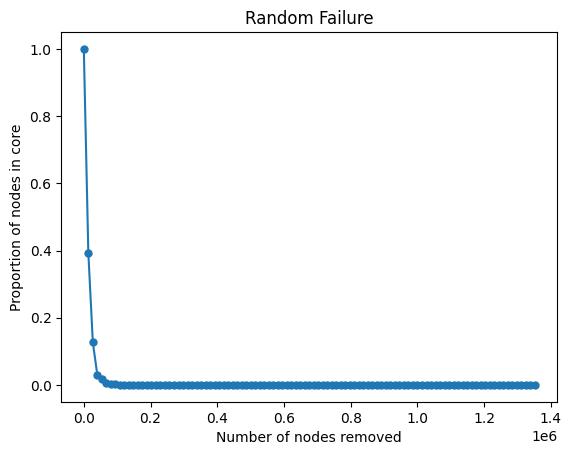

In [26]:
plt.title('Random Failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', markersize=5)

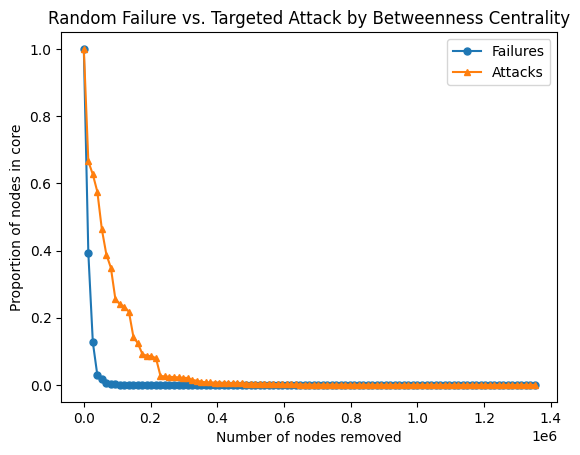

In [27]:
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.title('Random Failure vs. Targeted Attack by Betweenness Centrality')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures', markersize=5)
plt.plot(num_nodes_removed, targeted_attack_core_proportions_btwn, marker='^', label='Attacks', markersize=5)
plt.legend()

In [29]:
# Adopt code from Marta
N = G_sub_nx.number_of_nodes()
C = G_sub_nx.copy()
print(M)
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = max(nx.connected_components(C), key=len)
    core_proportion = len(core) / N
    
    # Save the largest connected component (core) nodes and edges to CSV
    C_core = C.subgraph(core).copy()  # Create a subgraph of the largest connected component

    # Save core nodes to CSV
    core_nodes_df = pd.DataFrame(C_core.nodes(data=True), columns=['Node ID', 'Attributes'])
    core_nodes_df = core_nodes_df.join(pd.json_normalize(core_nodes_df.pop("Attributes")))

    # Calculate log of betweenness centrality
    if 'Betweenness Centrality' in core_nodes_df.columns:
        core_nodes_df['Log Betweenness Centrality'] = np.log(core_nodes_df['Betweenness Centrality'].replace(0, np.nan))

    core_nodes_df.to_csv(f"/home/veronica/data/RA_Core_Nodes/RA_core_nodes_{nodes_removed}.csv", index=False)

    # Save core edges to CSV
    core_edges_df = pd.DataFrame(C_core.edges(data=True), columns=['Source', 'Target', 'Attributes'])
    core_edges_df = core_edges_df.join(pd.json_normalize(core_edges_df.pop("Attributes")))
    core_edges_df.to_csv(f"/home/veronica/data/RA_Core_Edges/RA_core_edges_{nodes_removed}.csv", index=False)

    random_attack_core_proportions.append(core_proportion)
    print(nodes_removed,core_proportion)

    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

    # Save removed nodes and their attributes to a csv file
        removed_nodes_data = []
        # Create a DataFrame with Node ID, Betweenness Centrality, Coordinates, and Step
        for node in nodes_to_remove:
            removed_nodes_data.append({
                "Node ID": node,
                "Betweenness Centrality": attributes[int(node)]['Betweenness Centrality'],
                "Longitude": attributes[int(node)]['Longitude'],
                "Latitude": attributes[int(node)]['Latitude'],
                "Step": nodes_removed
            })
        removed_nodes_df = pd.DataFrame(removed_nodes_data)
        removed_nodes_df.to_csv(f"/home/veronica/data/RandomAttack_Removal/RA_removed_nodes_{nodes_removed}.csv", index=False)



13518
0 1.0
13518 0.36821533110478727
27036 0.19593994317429483
40554 0.060712962134196545
54072 0.011170593252372855
67590 0.007112459712705449
81108 0.003940517201204569
94626 0.0014276700203350512
108144 0.0009002458107501333
121662 0.0007508212801243923
135180 0.0006420816464512044
148698 0.0005821638891210805
162216 0.0004467941410789487
175734 0.0004172051251134554
189252 0.0003439723105988595
202770 0.00034101340900231014
216288 0.0002685203198868516
229806 0.00015238343222229045
243324 0.00015016425602487846
256842 0.00015016425602487846
270360 0.00011613688766456116
283878 9.986292888353986e-05
297396 8.876704789647987e-05
310914 8.802732249734254e-05
324432 8.580814629993053e-05
337950 8.50684209007932e-05
351468 7.989034310683188e-05
364986 7.767116690941989e-05
378504 4.734242554478926e-05
392022 4.58629747465146e-05
405540 3.5506819158591946e-05
419058 3.4027368360317283e-05
432576 3.4027368360317283e-05
446094 3.4027368360317283e-05
459612 3.4027368360317283e-05
473130 3.

In [30]:
# Truncate the longer array to match the shorter one
min_length = min(len(num_nodes_removed), len(random_attack_core_proportions), len(targeted_attack_core_proportions_d))
num_nodes_removed = num_nodes_removed[:min_length]
random_attack_core_proportions = random_attack_core_proportions[:min_length]
targeted_attack_core_proportions_d = targeted_attack_core_proportions_d[:min_length]

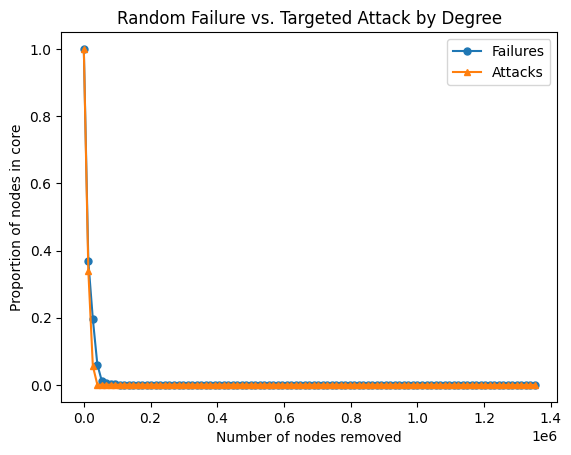

In [31]:
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.title('Random Failure vs. Targeted Attack by Degree')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures', markersize=5)
plt.plot(num_nodes_removed, targeted_attack_core_proportions_d, marker='^', label='Attacks', markersize=5)
plt.legend()